In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import seaborn as sns 
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
movie = pd.read_csv("movie.csv")
rating = pd.read_csv("rating.csv")

# Базовый осмотр данных

In [3]:
movie.sample(5)

,movieId,title,genres
490,494,Executive Decision (1996),Action|Adventure|Thriller
21751,105206,Amsterdamned (1988),Action|Horror|Thriller
21339,103688,"Conjuring, The (2013)",Horror|Thriller
21789,105325,Bad Milo (Bad Milo!) (2013),Comedy|Horror
2405,2490,Payback (1999),Action|Thriller


In [4]:
rating.sample(5)

,userId,movieId,rating,timestamp
15573930,107689,1214,4.0,2000-03-27 19:14:34
16182830,111988,913,5.0,1999-11-02 13:41:06
15489482,107126,7179,4.0,2006-01-10 17:15:27
16842571,116481,1945,4.5,2010-08-30 12:41:25
5201331,35629,778,5.0,1996-08-29 16:01:53


In [5]:
movie.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

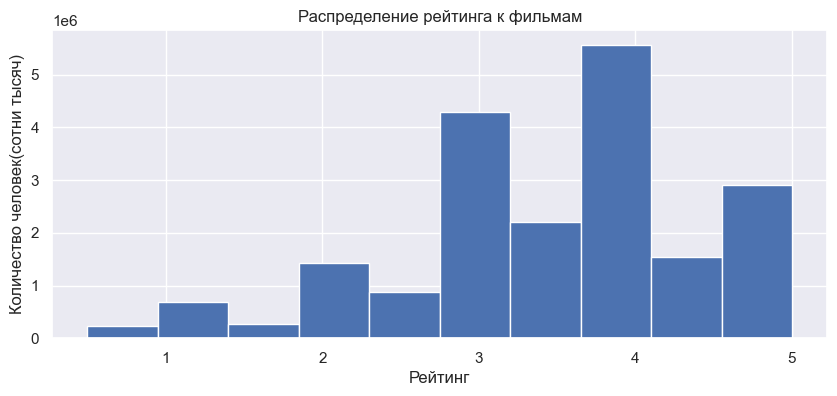

In [7]:
plt.figure(figsize=(10, 4))
plt.xlabel("Рейтинг")
plt.ylabel("Количество человек(сотни тысяч)")
plt.title("Распределение рейтинга к фильмам")
plt.hist(rating.rating);

# Baseline
#### Холодный старт
#### Предположим, что пользователю будет интересно смотреть фильмы с высоким рейтингом

In [8]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [9]:
top_movies = pd.DataFrame(rating.groupby(by='movieId', as_index=False)["rating"].mean().sort_values(by="rating", ascending=False))
top_movies = top_movies.reset_index(drop=True)
top_movies = top_movies.rename(columns={"rating": "mean_rating"})

top_movies.head()

,movieId,mean_rating
0,95517,5.0
1,105846,5.0
2,89133,5.0
3,105187,5.0
4,105191,5.0


In [10]:
recommended_movies = pd.merge(top_movies, movie,on='movieId', how='inner')

recommended_movies.head()

,movieId,mean_rating,title,genres
0,95517,5.0,"Barchester Chronicles, The (1982)",Drama
1,105846,5.0,Only Daughter (2013),Drama
2,89133,5.0,Boys (Drenge) (1977),Drama
3,105187,5.0,Linotype: The Film (2012),Documentary
4,105191,5.0,Rocaterrania (2009),Documentary|Fantasy


#### Добавим год к каждому фильму

In [11]:
raw_years = [i[-6:] for i in recommended_movies.title]
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for i in range(len(raw_years)):
    for j in range(len(raw_years[i])):
        if raw_years[i][j] not in digits:
            raw_years[i] = raw_years[i].replace(raw_years[i][j], ' ')

In [12]:
years = [int(i.replace(' ', '')) if len(i.replace(' ', '')) > 3 else np.nan for i in raw_years]

In [13]:
movie_year_df = pd.DataFrame({'movie_year': years})
movie_year_df.fillna(int(movie_year_df.movie_year.mean()), inplace=True)
movie_year_df = movie_year_df.astype({"movie_year": "Int64"})

In [14]:
recommended_movies = pd.concat([recommended_movies, movie_year_df], axis=1)
recommended_movies

,movieId,mean_rating,title,genres,movie_year
0,95517,5.0,"Barchester Chronicles, The (1982)",Drama,1982
1,105846,5.0,Only Daughter (2013),Drama,2013
2,89133,5.0,Boys (Drenge) (1977),Drama,1977
3,105187,5.0,Linotype: The Film (2012),Documentary,2012
4,105191,5.0,Rocaterrania (2009),Documentary|Fantasy,2009
...,...,...,...,...,...
26739,129784,0.5,Xuxa in Crystal Moon (1990),Children|Comedy|Romance,1990
26740,92479,0.5,Kisses for My President (1964),Comedy,1964
26741,129834,0.5,Tom and Jerry: The Lost Dragon (2014),Animation|Children|Comedy,2014
26742,115631,0.5,Alone for Christmas (2013),Action|Children|Comedy|Fantasy,2013


In [15]:
def recommend_movies_by_rating(n):
    films = recommended_movies[recommended_movies["mean_rating"] == 5].sample(n)
    return films

In [16]:
# Получить базовые рекомендации (топ-4 фильма по рейтингу)
recommend_movies_by_rating(4)

,movieId,mean_rating,title,genres,movie_year
51,72235,5.0,Between the Devil and the Deep Blue Sea (1995),Drama,1995
21,127256,5.0,The Old Gun (1975),Drama|Thriller|War,1975
9,105841,5.0,B-Side (2013),Comedy|Romance,2013
68,121063,5.0,The House on 56th Street (1933),Drama,1933


# Рекомендательная модель по жанрам, рейтингу и году выпуска фильма

In [17]:
recommended_movies[["genres"]].sample(5)
recommended_movies.shape

(26744, 5)

In [18]:
genres = np.array(recommended_movies[["genres"]]).tolist()
genres = [j for i in genres for j in i]
genres[0:5]

['Drama', 'Drama', 'Drama', 'Documentary', 'Documentary|Fantasy']

In [19]:
genres_split = [g.split('|') for g in genres]
genres_split[0:5]

[['Drama'], ['Drama'], ['Drama'], ['Documentary'], ['Documentary', 'Fantasy']]

### Преобразовываю жанры фильмов в бинарные векторы

In [20]:
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(genres_split)

print(mlb.classes_)
print(binary_matrix[0])

['(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'
 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
binary_genres = pd.DataFrame(binary_matrix, columns=mlb.classes_)
binary_genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
# Использую разряженную матрицу для оптимизации вычислительной мощности
sparse_matrix = csr_matrix(binary_genres)

In [23]:
def hybrid_recommend(movie_id):
    # Коэффициеты для каждого признака
    genre_weight = 0.5
    rating_weight = 0.3
    year_weight = 0.2

    nn = NearestNeighbors(n_neighbors=26744, metric='cosine', algorithm='brute')
    nn.fit(sparse_matrix)
    distances, indices = nn.kneighbors(sparse_matrix[movie_id])
    indices = [j for i in indices for j in i]
    distances = [j for i in distances for j in i]
    
    recommendations = pd.DataFrame({"distances": distances, "indices": indices}).sort_values(by="indices").reset_index()
    recommendations = recommendations.drop(['index', 'indices'], axis=1)
    df = recommended_movies
    res = pd.concat([df, recommendations], axis=1)
    res['year_distances'] =  np.exp(-0.1 * abs(res.movie_year.iloc[movie_id] - res['movie_year']))
    res['scores'] = round((genre_weight * (1 - res['distances'] + 0.0001)
                           + (res['mean_rating'] / 5) * rating_weight 
                           + res['year_distances'] * year_weight)*100, 2)
    
    return res.sort_values(by='scores', ascending=False)

In [24]:
# Получить персонализированные рекомендации для фильма с ID(номером строки) 12345
hybrid_recommend(12345).head(10)

,movieId,mean_rating,title,genres,movie_year,distances,year_distances,scores
12345,117851,3.279412,Penguins of Madagascar (2014),Adventure|Animation|Children|Comedy,2014,0.000000,1.0,89.68
15651,110655,3.080882,Rio 2 (2014),Adventure|Animation|Children|Comedy,2014,0.000000,1.0,88.49
19148,110130,2.884615,"Nut Job, The (2014)",Adventure|Animation|Children|Comedy,2014,0.000000,1.0,87.31
9642,94833,3.441667,"Pirates! Band of Misfits, The (2012)",Adventure|Animation|Children|Comedy,2012,0.000000,0.818731,87.03
9760,114552,3.434066,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy,2014,0.105573,1.0,85.33
10895,86298,3.361979,Rio (2011),Adventure|Animation|Children|Comedy,2011,0.000000,0.740818,84.99
16457,109102,3.000000,"Little Brother, Big Trouble: A Christmas Adven...",Adventure|Animation|Children|Comedy,2012,0.000000,0.818731,84.38
19105,105217,2.888889,Adventures in Zambezia (2012),Adventure|Animation|Children|Comedy,2012,0.000000,0.818731,83.71
10458,109846,3.390110,Mr. Peabody & Sherman (2014),Adventure|Animation|Comedy,2014,0.133975,1.0,83.65
3698,108932,3.750635,The Lego Movie (2014),Action|Adventure|Animation|Children|Comedy|Fan...,2014,0.183503,1.0,83.33
